# Fit the poly-spline-tccd acquisition probability model in 2018-04

Fit values here were computed 2018-Apr-03.  This is a candidate for the FLIGHT model.

This notebook fits the flight acquisition data using the `poly-spline-tccd` model.
This uses starting fit values from the accompanying `fit_acq_prob_model-2018-04-poly-tccd.ipynb` notebook.

This model is a 15-parameter fit for acquisition probability as a function of magnitude and CCD temperature.

See the final cells for best-fit values.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats
import tables3_api
from scipy.interpolate import CubicSpline
from Chandra.Time import DateTime

%matplotlib inline

## Get acq stats data and clean

In [2]:
with tables.open_file('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [3]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [4]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.
#
# UPDATE: is ion_rad being ignored on-board?
#
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['fail_mask'] = acqs['fail'].astype(bool)

In [5]:
# Allow for defining a 'mag' column that is the observed mag 
# if available else the catalog mag. This is a tempting thing
# to do for calibration, but it is incorrect because we want
# probabilities based on the information we have (catalog mag)
# not the information we wish we had (actual mag).  Thus the
# acq prob model folds in catalog mag uncertainty.  This is
# especially apparent for color=1.5.
USE_OBSERVED_MAG = False
if USE_OBSERVED_MAG:
    acqs['mag'] = np.where(acqs['fail_mask'], acqs['mag_aca'], acqs['mag_obs'])
else:
    acqs['mag'] = acqs['mag_aca']

In [6]:
# Filter for year and mag (previously used data through 2007:001)
#
# UPDATE this to be between 4 to 5 years from time of recalibration.
#
# The mag range is restricted to 8.5 < mag < 10.7 because the model
# is only calibrated in that range.  Above 10.7 there is concern that
# stats are actually unreliable (fraction of imposters that happen to
# is high?)  This upper limit is something to play with.
#
ok = (acqs['year'] > 2014.0) & (acqs['mag'] > 8.5) & (acqs['mag'] < 10.7)

In [7]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 41093
Filtering known bad obsids, end len = 41093


In [8]:
data_all = acqs[ok]
del data_all['img_func']
data_all.sort('year')

In [9]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (data_all['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
data_all['box_delta'] = b1 * box0 + b2 * box0**2

In [10]:
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

## Model definition

In [11]:
spline_mags = np.array([8.5, 9.25, 10.0, 10.4, 10.7])

def p_fail(pars, mag,
           tc, tc2=None,
           box_delta=0):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param wp: warm fraction
    :param box_delta: search box half width (arcsec)
    """
    p_bright_fail = 0.03  # For now

    p0s, p1s, p2s = pars[0:5], pars[5:10], pars[10:15]
    
    if tc2 is None:
        tc2 = tc ** 2
    
    # Make sure box_delta has right dimensions
    tc, box_delta = np.broadcast_arrays(tc, box_delta)

    p0 = CubicSpline(spline_mags, p0s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    p1 = CubicSpline(spline_mags, p1s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    p2 = CubicSpline(spline_mags, p2s, bc_type=((1, 0.0), (2, 0.0)))(mag)
    
    probit_p_fail = p0 + p1 * tc + p2 * tc2 + box_delta
    p_fail = stats.norm.cdf(probit_p_fail)  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    tc = data['t_ccd'] - (-12)
    tc2 = tc ** 2
    box_delta = data['box_delta']
    mag = data['mag']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, mag, tc, tc2, box_delta)

    return sherpa_func

In [12]:
def fit_poly_spline_model(data_mask=None):
    from sherpa import ui

    data = data_all if data_mask is None else data_all[data_mask]

    comp_names = [f'p{i}{j}' for i in range(3) for j in range(5)]
    
    # Approx starting values based on plot of p0, p1, p2
    # spline_mags = np.array([8.5, 9.25, 10.0, 10.4, 10.7])
    spline_p = {}
    spline_p[0] = np.array([-2.6, -2.0, -0.7, 0.3, 1.1])
    spline_p[1] = np.array([0.0, 0.0, 0.4, 0.7, 0.5])
    spline_p[2] = np.array([0.0, 0.0, 0.1, 0.1, 0.1])
    
    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for i in range(3):
        for j in range(5):
            comp_name = f'p{i}{j}'
            setattr(fmod, comp_name, spline_p[i][j])
            comp = getattr(fmod, comp_name)
            comp.max = 10
            comp.min = -4.0 if i == 0 else 0.0
            
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [13]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
#    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
#                 fmt='.' + colors[1:], label=label, markersize=8)
#    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    line, = plt.plot(data_mean[group_col], model_fail, '-')
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                        fmt='.', color=line.get_color(), label=label, markersize=8)
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [14]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [15]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [16]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [17]:
def plot_fit_all(parvals, mask=None, probit=False):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
     
    mt = mag_filter(8.5, 10.7) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((-12, -11, 'gk'), 
                               (-13, -12, 'cm'), 
                               (-14, -13, 'br'), 
                               (-15, -14, 'gk')):
            plot_fit_grouped(parvals, 'mag', 0.25, t_ccd_filter(v0, v1) & mt,
                             colors=colors, label=f'{v0} < t_ccd < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.ylabel('p_fail')
        plt.xlabel('year')
        plt.tight_layout()
        plt.grid()
    
    
    mt = t_ccd_filter(-16, -10) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((10.3, 10.7, 'gk'), 
                               (10, 10.3, 'cm'), 
                               (9.5, 10, 'br'), 
                               (9, 9.5, 'gk')):
            plot_fit_grouped(parvals, 'year', 0.25, mag_filter(v0, v1) & mt,
                             colors=colors, label=f'{v0} < mag < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.ylabel('p_fail')
        plt.xlabel('mag_aca')
        plt.tight_layout()
        plt.grid()
    
    mt = t_ccd_filter(-16, -10) & mask
    plt.figure(figsize=(12, 4))
    for probit in True, False:
        plt.subplot(1, 2, int(probit) + 1)
        for v0, v1, colors in ((10.3, 10.7, 'gk'), 
                               (10, 10.3, 'cm'), 
                               (9.5, 10, 'br'), 
                               (9, 9.5, 'gk')):
            plot_fit_grouped(parvals, 't_ccd', 0.5, mag_filter(v0, v1) & mt,  
                             colors=colors, label=f'{v0} < mag < {v1}', probit=probit)
        plt.legend(loc='upper left')
        plt.ylim(-3, 3) if probit else plt.ylim(-0.1, 1.1)
        plt.xlabel('t_ccd')
        plt.ylabel('p_fail')
        plt.tight_layout()
        plt.grid()

In [19]:
def plot_splines(pars):
    mag = np.arange(8.5, 11.01, 0.1)
    n = len(spline_mags)
    p0 = CubicSpline(spline_mags, pars[0:n], bc_type=((1, 0.0), (2, 0.0)))(mag)
    p1 = CubicSpline(spline_mags, pars[n:2*n], bc_type=((1, 0.0), (2, 0.0)))(mag)
    p2 = CubicSpline(spline_mags, pars[2*n:3*n], bc_type=((1, 0.0), (2, 0.0)))(mag)
    plt.plot(mag, p0, label='p0')
    plt.plot(mag, p1, label='p1')
    plt.plot(mag, p2, label='p2')
    plt.grid()
    plt.legend();


In [20]:
def print_model_coeffs(parvals):
    n = len(spline_mags)
    print(f'spline_mags = np.array({spline_mags.tolist()})')
    ln = 'spline_vals = np.array(['
    print(ln, end='')
    print(', '.join(f'{val:.4f}' for val in parvals[0:n]) + ',')
    print(' ' * len(ln) + ', '.join(f'{val:.4f}' for val in parvals[n:2*n]) + ',')
    print(' ' * len(ln) + ', '.join(f'{val:.4f}' for val in parvals[2*n:3*n]) + '])')

## Color != 1.5 fit (this is MOST acq stars)

In [22]:
mask_no_1p5 = data_all['color'] != 1.5

In [23]:
fit_no_1p5 = fit_poly_spline_model(mask_no_1p5)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 11626.7
Final fit statistic   = 10160.5 at function evaluation 7952
Data points           = 34593
Degrees of freedom    = 34578
Change in statistic   = 1466.14
   model.p00      -2.69826    
   model.p01      -1.96063    
   model.p02      -1.20245    
   model.p03      -0.0171341  
   model.p04      1.23724     
   model.p10      0.0713544   
   model.p11      0.127111    
   model.p12      0.145077    
   model.p13      0.596456    
   model.p14      0.642618    
   model.p20      0.0234136   
   model.p21      3.18928e-09 
   model.p22      0.0070419   
   model.p23      0.0692584   
   model.p24      0.0562922   


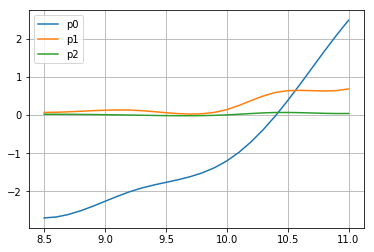

In [24]:
plot_splines(fit_no_1p5.parvals)

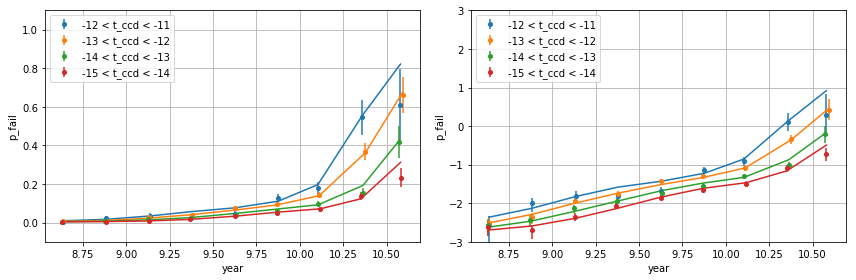

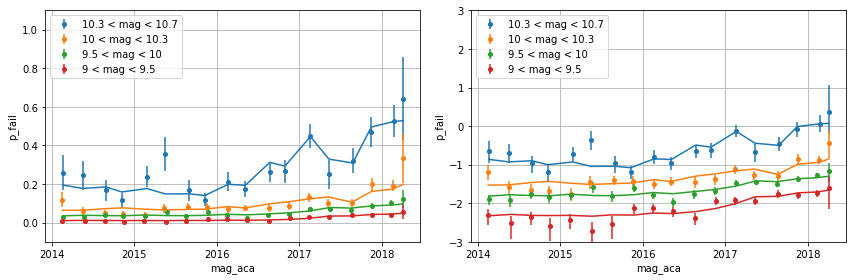

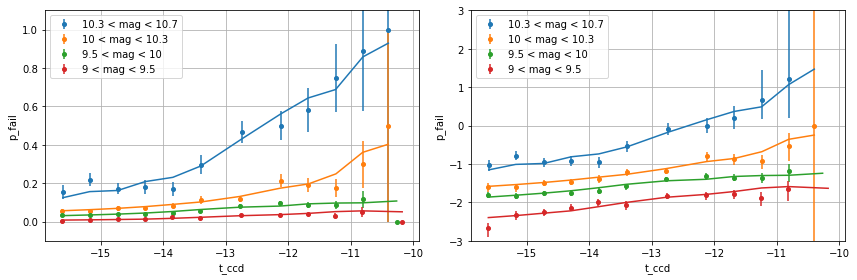

In [25]:
plot_fit_all(fit_no_1p5.parvals, mask_no_1p5)

### Focus on 10.3 to 10.6 mag bin for recent times

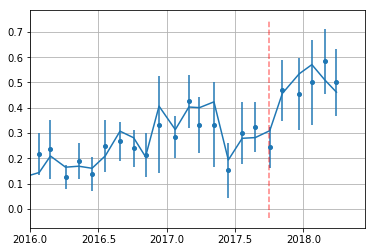

In [26]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.3, 10.6) & mask_no_1p5,  
                 colors='gk', label='10.3 < mag < 10.6')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

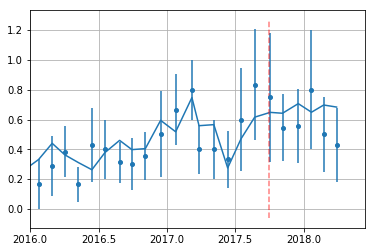

In [27]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.5, 10.7) & mask_no_1p5,  
                 colors='gk', label='10.5 < mag < 10.7')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

### Focus on 10.0 to 10.3 mag bin for recent times

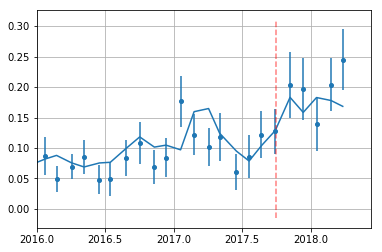

In [28]:
plot_fit_grouped(fit_no_1p5.parvals, 'year', 0.10, mag_filter(10.0, 10.3) & mask_no_1p5,  
                 colors='gk', label='10.0 < mag < 10.3')
plt.xlim(2016.0, None)
y0, y1 = plt.ylim()
x = DateTime('2017-10-01T00:00:00').frac_year
plt.plot([x, x], [y0, y1], '--r', alpha=0.5)
plt.grid();

## Color == 1.5 fit

In [29]:
print('Hang tight, this could take a few minutes')
mask_1p5 = data_all['color'] == 1.5
fit_1p5 = fit_poly_spline_model(mask_1p5)

Hang tight, this could take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 2981.11
Final fit statistic   = 2833.65 at function evaluation 6844
Data points           = 6500
Degrees of freedom    = 6485
Change in statistic   = 147.452
   model.p00      -2.56169    
   model.p01      -1.65157    
   model.p02      -0.267938   
   model.p03      1.00488     
   model.p04      3.52181     
   model.p10      1.80887e-07 
   model.p11      0.0919285   
   model.p12      0.230264    
   model.p13      0.612432    
   model.p14      0.941565    
   model.p20      0.00471001  
   model.p21      0.00636793  
   model.p22      0.0111776   
   model.p23      0.0746107   
   model.p24      0.0955562   


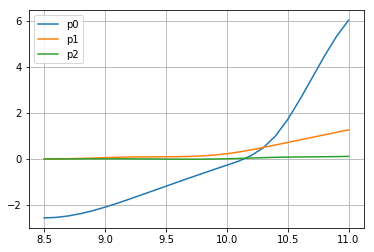

In [30]:
plot_splines(fit_1p5.parvals)

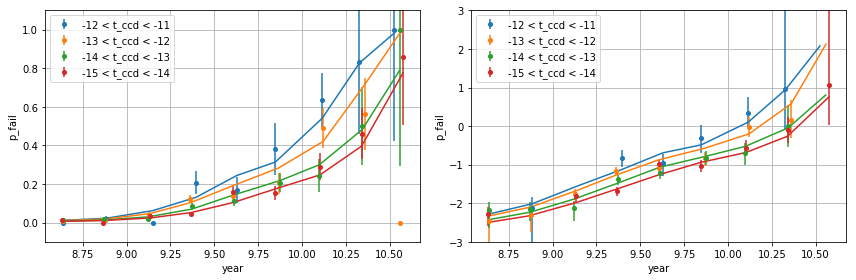

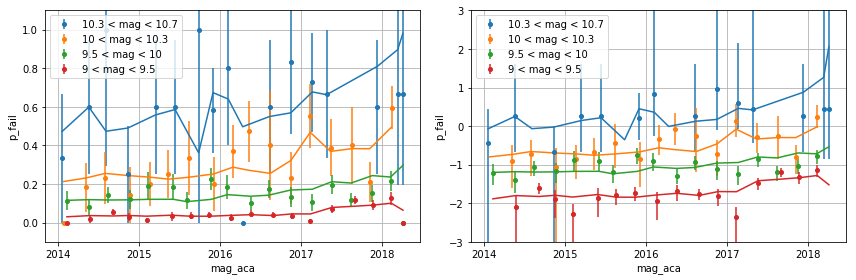

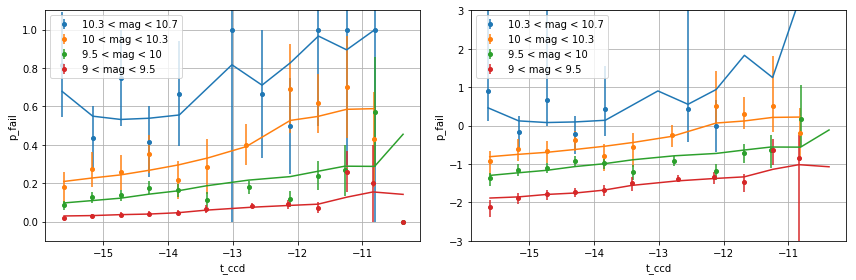

In [31]:
plot_fit_all(fit_1p5.parvals, mask=mask_1p5)

### Histogram of warm pixel fraction

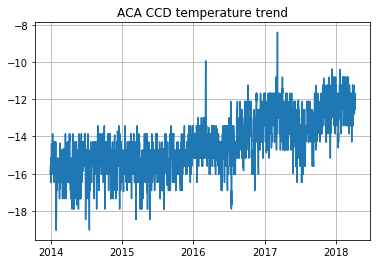

In [32]:
plt.plot(data_all['year'], data_all['t_ccd'])
plt.title('ACA CCD temperature trend')
plt.grid();

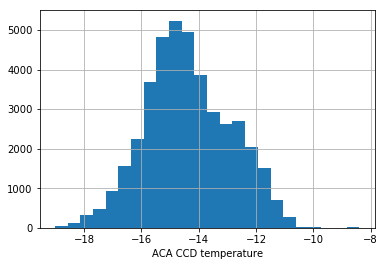

In [33]:
plt.hist(data_all['t_ccd'], bins=24)
plt.grid()
plt.xlabel('ACA CCD temperature');

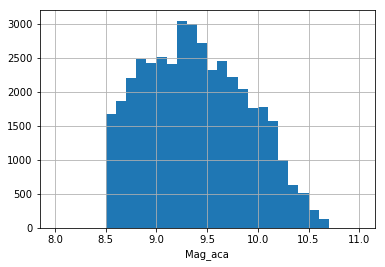

In [34]:
plt.hist(data_all['mag'], bins=np.arange(8.0, 11.1, 0.1))
plt.grid()
plt.xlabel('Mag_aca');

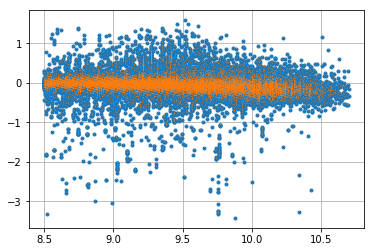

In [35]:
ok = ~data_all['fail'].astype(bool)
dok = data_all[ok]
plt.plot(dok['mag_aca'], dok['mag_obs'] - dok['mag_aca'], '.')
plt.plot(dok['mag_aca'], dok['mag_obs'] - dok['mag_aca'], ',', alpha=0.3)
plt.grid()

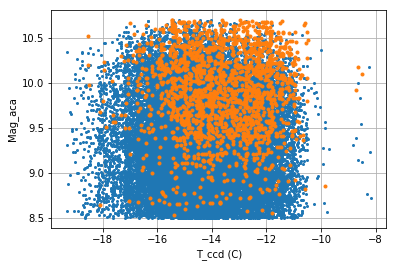

In [36]:
da = data_all
ok = ~da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C0', markersize=4)

ok = da['fail'].astype(bool)
fuzz = np.random.uniform(-0.3, 0.3, np.count_nonzero(ok))
plt.plot(da['t_ccd'][ok] + fuzz, da['mag_aca'][ok], '.C1')
plt.xlabel('T_ccd (C)')
plt.ylabel('Mag_aca')
plt.grid()

## Compare with flight model circa Mar-2018

**Note**: this code will likely give different results when new model is promoted to flight.  Will need to specify SOTA model if re-run later.

In [37]:
from chandra_aca.star_probs import acq_success_prob

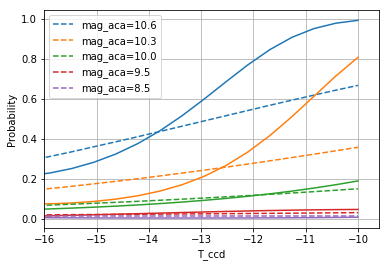

In [38]:
t_ccds = np.linspace(-18, -10, 20)
mag_acas = [8.5, 9.5, 10.0, 10.3, 10.6]

for ii, mag_aca in enumerate(reversed(mag_acas)):
    flight_probs = 1 - acq_success_prob(date='2018-05-01T00:00:00', t_ccd=t_ccds, mag=mag_aca)
    new_probs = p_fail(fit_no_1p5.parvals, mag_aca, t_ccds + 12)
    plt.plot(t_ccds, flight_probs, '--', label=f'mag_aca={mag_aca}', color=f'C{ii}')
    plt.plot(t_ccds, new_probs, '-', color=f'C{ii}')

plt.xlim(-16, None)
plt.legend()
plt.xlabel('T_ccd')
plt.ylabel('Probability')
plt.grid()

## Final fit values for `chandra_aca.star_probs`

In [44]:
def print_parvals(parvals, label):
    print('{:s} = np.array([{:s},  # P0 values'
          .format(label, ', '.join(str(round(x, 5)) for x in parvals[0:5])))
    print(' ' * len(label) + '             {:s},  # P1 values'
          .format(', '.join(str(round(x, 5)) for x in parvals[5:10])))
    print(' ' * len(label) + '             {:s}])  # P2 values'
          .format(', '.join(str(round(x, 5)) for x in parvals[0:5])))

In [46]:
print_parvals(fit_no_1p5.parvals, 'fit_no_1p5')

fit_no_1p5 = np.array([-2.69826, -1.96063, -1.20245, -0.01713, 1.23724,  # P0 values
                       0.07135, 0.12711, 0.14508, 0.59646, 0.64262,  # P1 values
                       -2.69826, -1.96063, -1.20245, -0.01713, 1.23724])  # P2 values


In [47]:
print_parvals(fit_1p5.parvals, 'fit_1p5')

fit_1p5 = np.array([-2.56169, -1.65157, -0.26794, 1.00488, 3.52181,  # P0 values
                    0.0, 0.09193, 0.23026, 0.61243, 0.94157,  # P1 values
                    -2.56169, -1.65157, -0.26794, 1.00488, 3.52181])  # P2 values


In [51]:
print('spline_mags = np.array([{:s}])'.format(', '.join(str(x) for x in spline_mags)))

spline_mags = np.array([8.5, 9.25, 10.0, 10.4, 10.7])
